In [4]:
import pandas as pd
%load_ext autoreload
%autoreload 2
import itertools
import numpy as np
import seaborn as sns
from scipy import interpolate
from scipy.stats import pearsonr
import os
import matplotlib.pyplot as plt
from rdkit import Chem,  DataStructs
from scipy.signal import find_peaks
import toolsets.spectra_operations as so
from toolsets.search import quick_search_values, string_search
from toolsets.uv_toolsets import read_in_uv

In [5]:
from toolsets.setup import set_workspace, get_dirs
master_dir = '/Volumes/Natural Product Chemistry/Working Space/Fanzhou/Myristica'

set_workspace(master_dir)
# this is the master workspace, all other directories will be created within this workspace
dirs =get_dirs(master_dir, mode='pos')

the workspace exists!
set up complete
at position 0:  /Volumes/Natural Product Chemistry/Working Space/Fanzhou/Myristica/alignment_result/pos
at position 1:  /Volumes/Natural Product Chemistry/Working Space/Fanzhou/Myristica/bioactivity
at position 2:  /Volumes/Natural Product Chemistry/Working Space/Fanzhou/Myristica/mzml/pos
at position 3:  /Volumes/Natural Product Chemistry/Working Space/Fanzhou/Myristica/normalized_peak_list/pos
at position 4:  /Volumes/Natural Product Chemistry/Working Space/Fanzhou/Myristica/peak_list/pos
at position 5:  /Volumes/Natural Product Chemistry/Working Space/Fanzhou/Myristica/results/pos
at position 6:  /Volumes/Natural Product Chemistry/Working Space/Fanzhou/Myristica/sirius_files/pos
at position 7:  /Volumes/Natural Product Chemistry/Working Space/Fanzhou/Myristica/uv_data
at position 8:  /Volumes/Natural Product Chemistry/Working Space/Fanzhou/Myristica/nmr_data
at position 9:  /Volumes/Natural Product Chemistry/Working Space/Fanzhou/Myristica/uv_li

# read in standard info

In [6]:
uv_lib_dir = dirs[9]
std_info_name = 'STP000030.csv'
std_info = pd.read_csv(os.path.join(dirs[9], std_info_name))

In [7]:
std_info

,BSD_ID,Name,CAS,amount [mg],plate ID,position,analytical method,purity [%],PO,Collection,Novelty,Similar_V,formula,molweight,SMILES
0,STD002562,NaN,NaN,1,AD236549-01,A01,HPLC ELSD,99,PO7669-2023,MEGxp,N,NP-023852,C20H20O5,340.375,CC1C(C)C(OC1C1=CC=C2OCOC2=C1)C1=CC2=C(OCO2)C=C1
1,STD002563,NaN,NaN,1,AD236549-01,A02,HPLC ELSD,96,PO7669-2023,MEGxp,N,NaN,C21H26O4,342.435,COC1=C(OC)C=C(CC(C)C(C)CC2=CC3=C(OCO3)C=C2)C=C1
2,STD002564,NaN,NaN,1,AD236549-01,A03,NMR,70,PO7669-2023,MEGxp,N,"NP-000261, NP-005010, NP-015800; NP-019154",C20H24O5,344.407,COC1=CC(=CC=C1O)C1OC(C(C)C1C)C1=CC(OC)=C(O)C=C1
3,STD002565,NaN,NaN,1,AD236549-01,A04,HPLC ELSD,100,PO7669-2023,MEGxp,N,NP-012845,C20H22O4,326.392,CC(CC1=CC2=C(OCO2)C=C1)C(C)CC1=CC2=C(OCO2)C=C1
4,STD002566,Myristicin,607-91-0,1,AD236549-01,A05,NMR,70,PO7669-2023,MEGxp,N,NaN,C11H12O3,192.214,COC1=CC(CC=C)=CC2=C1OCO2
5,STD002567,NaN,NaN,1,AD236549-01,B01,HPLC ELSD,94,PO7669-2023,MEGxp,N,NaN,C14H17NO6,295.291,OCC1OC(OC(C#N)C2=CC=CC=C2)C(O)C(O)C1O
6,STD002568,Rutin,153-18-4,1,AD236549-01,B02,HPLC ELSD,100,PO7669-2023,MEGxp,N,NP-007121,C27H30O16,610.521,C[C@@H]1O[C@@H](OC[C@H]2O[C@@H](OC3=C(OC4=CC(O...
7,STD002569,NaN,NaN,1,AD236549-01,B03,HPLC ELSD,96,PO7669-2023,MEGxp,N,NP-012906,C20H20O5,340.375,CC1C(C)C(OC1C1=CC=C2OCOC2=C1)C1=CC2=C(OCO2)C=C1
8,STD002570,Dihydrogualaretic acid,ng,1,AD236549-01,B04,HPLC ELSD,88,PO7669-2023,MEGxp,N,NP-004155,C20H26O4,330.424,COC1=CC(CC(C)C(C)CC2=CC(OC)=C(O)C=C2)=CC=C1O
9,STD002571,NaN,NaN,1,AD236549-01,C01,HPLC ELSD,100,PO7669-2023,MEGxp,N,NP-013791,C20H24O4,328.408,COC1=C(O)C=CC(CC(C)C(C)CC2=CC3=C(OCO3)C=C2)=C1


# standardizing smiles (optional)

In [16]:
cleaned_smiles = []
for index, row in std_info.iterrows():
    mol = Chem.MolFromSmiles(row['SMILES'])
    cleaned_smiles.append(Chem.MolToSmiles(mol))
std_info['smiles']=cleaned_smiles
std_info.drop(['SMILES'], inplace=True, axis=1)

# get file names

In [13]:
file_list = []
for index, row in std_info.iterrows():

    if os.path.exists(os.path.join(uv_lib_dir, row['BSD_ID']+'_P.csv')):
        file_list.append(row['BSD_ID'])

In [14]:
file_list

['STD002562',
 'STD002563',
 'STD002564',
 'STD002565',
 'STD002566',
 'STD002568',
 'STD002569',
 'STD002570',
 'STD002571',
 'STD002572',
 'STD002573',
 'STD002574',
 'STD002575',
 'STD002576',
 'STD002577',
 'STD002579',
 'STD002580',
 'STD002581',
 'STD002582',
 'STD002583',
 'STD002584',
 'STD002586',
 'STD002587',
 'STD002588',
 'STD002589',
 'STD002590',
 'STD002591',
 'STD002593',
 'STD002594']

# curate UV library

In [8]:

# place where all uv files are stored

In [17]:
uv_lib = pd.DataFrame()
smile = []
brd_id = []
uv_spec  = []
for f in file_list:
    brd_id.append(f)
    uv_temp = read_in_uv(os.path.join(uv_lib_dir, f+'_P.csv'))
    uv_spec.append(so.pack_spectra(uv_temp['Wavelength'].tolist(), uv_temp['Intensity_normalized'].tolist()))
    smile.append(string_search(std_info, 'BSD_ID', f).iloc[0]['smiles'])
uv_lib = pd.DataFrame(zip(brd_id, smile, uv_spec), columns=['BRD_ID', 'smile', 'uv_spec'])

In [18]:
uv_lib

,BRD_ID,smile,uv_spec
0,STD002562,CC1C(c2ccc3c(c2)OCO3)OC(c2ccc3c(c2)OCO3)C1C,190\t0.02644053484898539\n200\t0.0321540771201...
1,STD002563,COc1ccc(CC(C)C(C)Cc2ccc3c(c2)OCO3)cc1OC,190\t0.027607132633658184\n200\t0.032129707141...
2,STD002564,COc1cc(C2OC(c3ccc(O)c(OC)c3)C(C)C2C)ccc1O,190\t0.026068764946450978\n200\t0.031337822719...
3,STD002565,CC(Cc1ccc2c(c1)OCO2)C(C)Cc1ccc2c(c1)OCO2,190\t0.021625014936727183\n200\t0.028389458962...
4,STD002566,C=CCc1cc(OC)c2c(c1)OCO2,190\t0.026519140965286958\n200\t0.035099307891...
5,STD002568,C[C@@H]1O[C@@H](OC[C@H]2O[C@@H](Oc3c(-c4ccc(O)...,190\t0.015396252960696811\n200\t0.019711912115...
6,STD002569,CC1C(c2ccc3c(c2)OCO3)OC(c2ccc3c(c2)OCO3)C1C,190\t0.026515214499501165\n200\t0.033337490300...
7,STD002570,COc1cc(CC(C)C(C)Cc2ccc(O)c(OC)c2)ccc1O,190\t0.03255997633731194\n200\t0.0349297186635...
8,STD002571,COc1cc(CC(C)C(C)Cc2ccc3c(c2)OCO3)ccc1O,190\t0.03510571029185518\n200\t0.0293845743240...
9,STD002572,Oc1cc(O)c2c(c1)O[C@H](c1ccc(O)c(O)c1)[C@@H](O)C2,190\t0.019829671263981125\n200\t0.042025299514...


In [21]:
uv_lib = pd.read_csv(os.path.join(uv_lib_dir, 'uv_lib.csv'))

In [22]:
uv_lib

,BRD_ID,smile,uv_spec
0,luteolin,C1=CC(=C(C=C1C2=CC(=O)C3=C(C=C(C=C3O2)O)O)O)O,190\t0.019397656269877907\n200\t0.035237129415...
1,STD002562,CC1C(c2ccc3c(c2)OCO3)OC(c2ccc3c(c2)OCO3)C1C,190\t0.02644053484898539\n200\t0.0321540771201...
2,STD002563,COc1ccc(CC(C)C(C)Cc2ccc3c(c2)OCO3)cc1OC,190\t0.027607132633658184\n200\t0.032129707141...
3,STD002564,COc1cc(C2OC(c3ccc(O)c(OC)c3)C(C)C2C)ccc1O,190\t0.026068764946450978\n200\t0.031337822719...
4,STD002565,CC(Cc1ccc2c(c1)OCO2)C(C)Cc1ccc2c(c1)OCO2,190\t0.021625014936727183\n200\t0.028389458962...
5,STD002566,C=CCc1cc(OC)c2c(c1)OCO2,190\t0.026519140965286958\n200\t0.035099307891...
6,STD002568,C[C@@H]1O[C@@H](OC[C@H]2O[C@@H](Oc3c(-c4ccc(O)...,190\t0.015396252960696811\n200\t0.019711912115...
7,STD002569,CC1C(c2ccc3c(c2)OCO3)OC(c2ccc3c(c2)OCO3)C1C,190\t0.026515214499501165\n200\t0.033337490300...
8,STD002570,COc1cc(CC(C)C(C)Cc2ccc(O)c(OC)c2)ccc1O,190\t0.03255997633731194\n200\t0.0349297186635...
9,STD002571,COc1cc(CC(C)C(C)Cc2ccc3c(c2)OCO3)ccc1O,190\t0.03510571029185518\n200\t0.0293845743240...


# write to csv

In [16]:
uv_lib_name = 'uv_lib.csv' # place where you want to write the uv_lib to
uv_lib.to_csv(os.path.join(uv_lib_dir, uv_lib_name), index = False)

# some visulization functions

In [21]:
from toolsets.uv_toolsets import uv_plot

In [19]:
uv_lib

,BRD_ID,smile,uv_spec
0,STD002562,CC1C(c2ccc3c(c2)OCO3)OC(c2ccc3c(c2)OCO3)C1C,190\t0.02644053484898539\n200\t0.0321540771201...
1,STD002563,COc1ccc(CC(C)C(C)Cc2ccc3c(c2)OCO3)cc1OC,190\t0.027607132633658184\n200\t0.032129707141...
2,STD002564,COc1cc(C2OC(c3ccc(O)c(OC)c3)C(C)C2C)ccc1O,190\t0.026068764946450978\n200\t0.031337822719...
3,STD002565,CC(Cc1ccc2c(c1)OCO2)C(C)Cc1ccc2c(c1)OCO2,190\t0.021625014936727183\n200\t0.028389458962...
4,STD002566,C=CCc1cc(OC)c2c(c1)OCO2,190\t0.026519140965286958\n200\t0.035099307891...
5,STD002568,C[C@@H]1O[C@@H](OC[C@H]2O[C@@H](Oc3c(-c4ccc(O)...,190\t0.015396252960696811\n200\t0.019711912115...
6,STD002569,CC1C(c2ccc3c(c2)OCO3)OC(c2ccc3c(c2)OCO3)C1C,190\t0.026515214499501165\n200\t0.033337490300...
7,STD002570,COc1cc(CC(C)C(C)Cc2ccc(O)c(OC)c2)ccc1O,190\t0.03255997633731194\n200\t0.0349297186635...
8,STD002571,COc1cc(CC(C)C(C)Cc2ccc3c(c2)OCO3)ccc1O,190\t0.03510571029185518\n200\t0.0293845743240...
9,STD002572,Oc1cc(O)c2c(c1)O[C@H](c1ccc(O)c(O)c1)[C@@H](O)C2,190\t0.019829671263981125\n200\t0.042025299514...


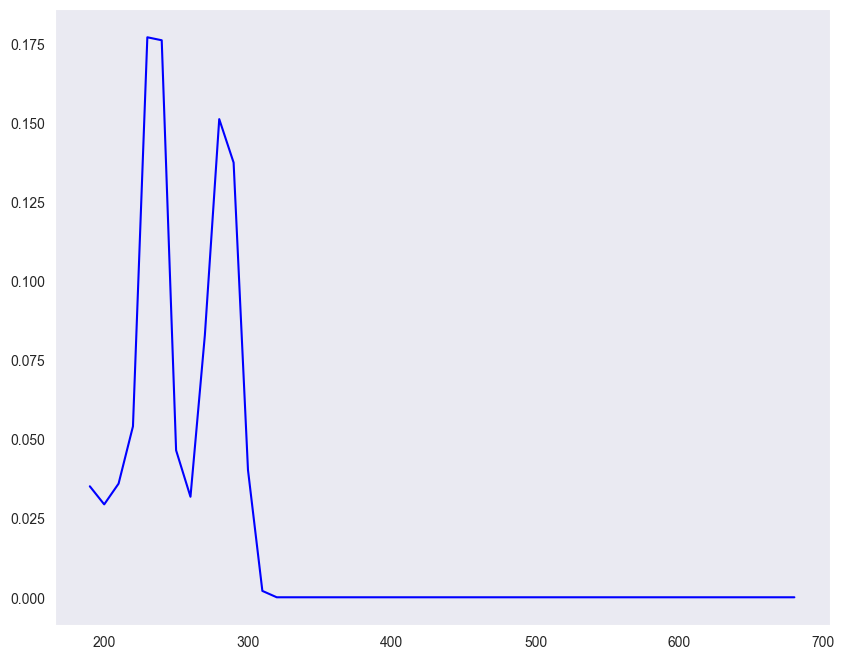

In [23]:
idx = 8
uv_plot(uv_lib.iloc[idx]['uv_spec'])